Libraries imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D, Bidirectional

2024-04-20 21:00:27.232058: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-20 21:00:27.235066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-20 21:00:27.235083: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/robertomedina/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing dataset

In [2]:
rt_train = pd.read_csv('./data/rotten_tomatoes/train.csv', sep='\t', names=['Stuff', 'Sentiment', 'Text'])
rt_test = pd.read_csv('./data/rotten_tomatoes/test.csv', sep='\t', names=['Stuff', 'Sentiment', 'Text'])

rt_train = rt_train.drop(labels='Stuff',axis=1)
rt_test = rt_test.drop(labels='Stuff',axis=1)

rt_test

,Sentiment,Text
0,negative,With a tighter editorial process and firmer di...
1,positive,If ever a concept came handed down from the mo...
2,negative,Whether Jason X is this bad on purpose is neve...
3,positive,Alternates between deadpan comedy and heartbre...
4,neutral,"God is great , the movie 's not ."
...,...,...
1724,neutral,Innocuous enough to make even Jean-Claude Van ...
1725,positive,A sensitive and astute first feature by Anne-S...
1726,positive,"Brilliantly written and well-acted , Yellow As..."
1727,positive,"And it sees those relationships , including th..."


Grouping the training data by sentiment and calculating the count of each sentiment, to calculate the percentage of each sentiment and then plot them into a Pie Chart

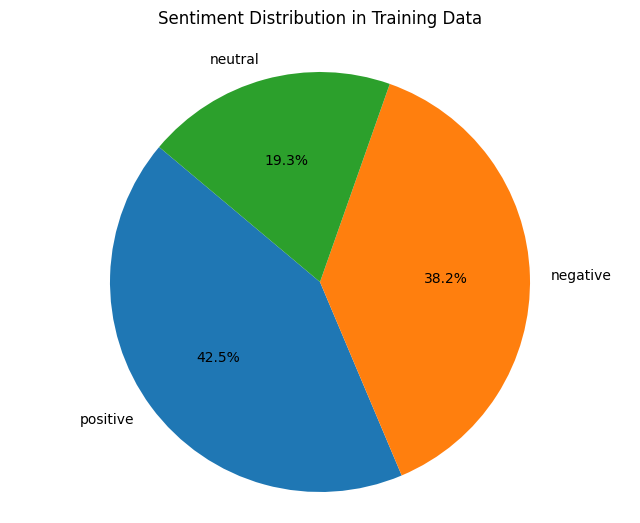

In [3]:
sentiment_counts_train = rt_train['Sentiment'].value_counts()
sentiment_percentages_train = (sentiment_counts_train / sentiment_counts_train.sum()) * 100

plt.figure(figsize=(8, 6))
plt.pie(sentiment_percentages_train, labels=sentiment_percentages_train.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Training Data', pad=20)
plt.axis('equal')
plt.show()

Grouping the test data by sentiment and calculating the count of each sentiment, to calculate the percentage of each sentiment and then plot them into a Pie Chart

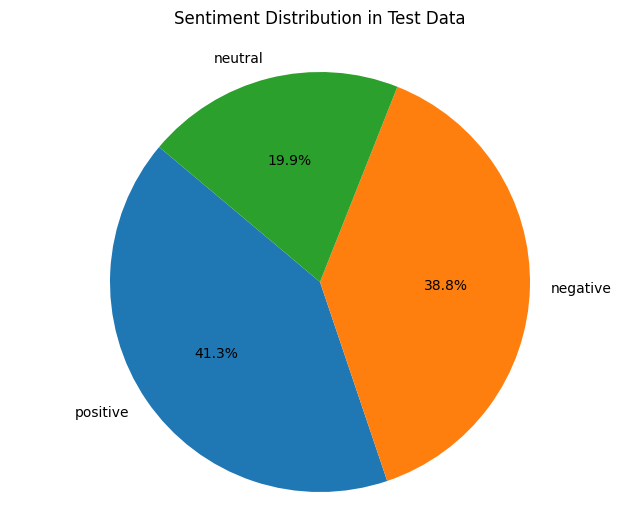

In [4]:
sentiment_counts_train = rt_test['Sentiment'].value_counts()
sentiment_percentages_train = (sentiment_counts_train / sentiment_counts_train.sum()) * 100

plt.figure(figsize=(8, 6))
plt.pie(sentiment_percentages_train, labels=sentiment_percentages_train.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution in Test Data', pad=20)
plt.axis('equal')
plt.show()

Function to plot confusion matrixs

In [5]:
def make_confusion_matrics(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', 
                xticklabels=['Negative', 'Neutral', 'Positive'], 
                yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Function to determinate the value of the Accurary, Precision, Recall and F1 Score

In [6]:
def determinate_metrics_values(y_pred):
    y_true = rt_test['Sentiment'].to_list()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

# 1.2 Definição de um baseline usando ferramentas já existentes
Verifique que os dados se encontram subdividos em conjuntos de treino e teste. Pretende-se agora fazer uma classificação inicial dos dados de teste usando uma ferramenta de análise de sentimentos já existente com modelos pré-treinados. Para isso, deve procurar e escolher uma ferramenta que permita fazer Análise de Sentimento diretamente a um texto. Uma possível ferramenta é a biblioteca TextBlob que se encontra lustrada nos exemplos da aula, mas poderá usar outra tal como Vader Sentiment 1 , spacy ou Stanza 2.

Aplique a ferramenta escolhida aos seus dados de teste e avalie os resultados obtidos utilizando as métricas adotadas. Note que a taxa de acerto (accuracy) poderá ser a mais adequada para problemas binários, em que ambas as classes têm igual importância. Para outros problemas poderá fazer sentido usar outras métricas, tais como: precisão, cobertura e medida F1.

## TextBlob Analysis
Because there are three classes (negative, neutral and positive), we are defining equally sized intevals of values to pick the sentiment that TextBlob returns. The range which TextBlob returns the text polarity is between -1.0 and 1.0. If we seperate this interval in equal parts we get [-1.0, -0.33[ for the negative sentiment, [-0.33, 0.33] for neutral sentiment and ]0.33, 1.0] for positive sentiment.

TextBlob inner workings:

In [ ]:
text = rt_test.at[0, 'Text']
text_analysis = TextBlob(text)
print('Sentiment and Text: \n', rt_test.iloc[0])
text_analysis.sentiment_assessments

In [ ]:
# TextBlob testing fucntion

def tb_eval(rt_data):
    est = []
    des = []

    for row in rt_data.iterrows():
        text_analysis = TextBlob(row[1].at['Text'])

        if text_analysis.sentiment.polarity < -0.01:
            est.append('negative')
        elif text_analysis.sentiment.polarity > 0.01:
            est.append('positive')
        else:
            est.append('neutral')

        des.append(row[1].at['Sentiment'])

    return est, des

Test with raw data:

In [ ]:
estimated, desired =  tb_eval(rt_test)

accuracy = accuracy_score(desired, estimated)
print(f'Accuracy: {accuracy}')

precision = precision_score(desired, estimated, average='weighted')
print(f'Precision: {precision}')

recall = recall_score(desired, estimated, average='weighted')
print(f'Recall: {recall}')

f1 = f1_score(desired, estimated, average='weighted')
print(f'F1 Score: {f1}')

# 1.3 Preparação de dados e aplicação de um léxico de sentimentos
Pretende-se agora fazer um classificador de sentimentos muito simples, baseado num léxico. Para tal, pode utilizar o NRC Word-Emotion Association Lexicon (EmoLex) que se encontra disponível dentro da diretoria ./data/NCR-lexicon.csv. O ficheiro original é um ficheiro do tipo CSV que tem o seguinte conteúdo, embora apenas as primeiras 3 colunas do ficheiro (English, Positive, Negative) sejam suficientes para este trabalho.

| English             | Positive | Negative | Anger | Anticipation | Disgust | Fear | ...
| ----------------- | --------- | -------- | ------- | ---------- | --------- | -------- | ------- |
| abacus      |      0     |    0     |   0   |       0      |    0    |   0  | ...
| abandoned   |      0     |    1     |   1   |       0      |    0    |   1  | ...
| abandonment |      0     |    1     |   1   |       0      |    0    |   1  | ...
| abba        | 1 | 0 | 0 | 0 | 0 | 0 |...
| ... | ... | ... | ... | ... | ... | ... | ...

Mais uma vez, pretende-se fazer a classificação dos dados de teste. Deverá procurar alguma bibliografia que reporte a utilização de léxicos de polaridade por forma a decidir qual a melhor abordagem. No entanto, a ideia geral é quantificar quantas palavras do texto a analisar estão classificadas como Positive e Negative e neutral, consoante a classe mais frequente, decidir qual a classificação final a atribuír ao texto.

Poderá utilizar outros léxicos alternativos e deverá também fazer algum pré-processamento por forma a melhorar o desempenho obtido. Deve fazer pelo menos duas experiências diferentes: sem e com o tratamento da negação, comentando os respetivos resultados obtidos


Definição da classe do Lexical Classifier

In [112]:
import spacy
import string
import pandas as pd

class LexicalClassifier:
    def __init__(self, lexicon_file):
        self.lexicon = self.load_lexicon(lexicon_file)
        self.nlp = spacy.load("en_core_web_sm")
        self.negation_list = {"not", "n't", "no", "never", "none", "nor", "neither"}

    def load_lexicon(self, lexicon_file):
        lexicon_df = pd.read_csv(lexicon_file)
        lexicon_df.set_index('English', inplace=True)
        return lexicon_df
    
    def preprocess_text(self, text):
        negated_text = self.negate_text(text)
        words = self.tokenize(negated_text)
        return words
    
    def classify(self, text):
        positive_count = 0
        negative_count = 0
        words = self.preprocess_text(text)
        for word in words:
            if word in self.lexicon.index:
                if word.startswith("NOT_"):
                    negative_count += 1
                else:
                    positive_count += self.lexicon.loc[word, 'Positive']
                    negative_count += self.lexicon.loc[word, 'Negative']
        
        if positive_count > negative_count:
            return 'positive'
        elif negative_count > positive_count:
            return 'negative'
        else:
            return 'neutral'

    def negate_text(self, text):
        words_list = self.tokenize(text)
        negated_text = []
        negation = False

        for word in words_list:
            if word.lower() in self.negation_list:
                negation = True
                negated_text.append('NOT_' + word)
            elif word in string.punctuation:
                negation = False
                negated_text.append(word)
            elif negation:
                negated_text.append('NOT_' + word)
            else:
                negated_text.append(word)

        return ' '.join(negated_text)
    
    def tokenize(self, text):
        doc = self.nlp(text)
        tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
        return text.split(" ")

Testando Lexical Classifier nos dados de teste

In [113]:
classifier = LexicalClassifier('./data/NRC-Emotion-Lexicon.csv')

predicted_sentiments = [classifier.classify(text) for text in rt_test['Text'].to_list()]

determinate_metrics_values(predicted_sentiments)

Accuracy: 0.44650086755349916
Precision: 0.5090433437059708
Recall: 0.44650086755349916
F1 Score: 0.4549623110682792


Plot da matriz de confusão

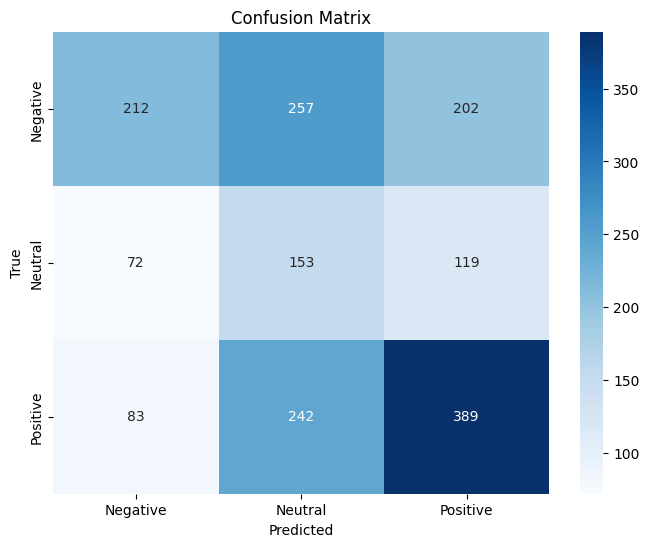

In [111]:
y_true = rt_test['Sentiment'].to_list()
make_confusion_matrics(y_true, predicted_sentiments)

# 4 Treino de um modelo (aprendizagem automática)
Deverá agora tentar treinar um modelo, com o objetivo de tentar melhorar ainda mais os resultados de classificação obtidos:

1. Treine um modelo com os dados de treino, usando uma ferramenta de classificação à sua escolha, tal como por exemplo scikit-learn, etc.
2. Aplique o modelo que construiu ao conjunto de teste, avalie os resultados obtidos e compare-os com os resultados obtidos na tarefa anterior.

Faça várias experiências usando diferentes conjuntos ou tipos de features e documente os resultados obtidos. Exemplos de experiências: variar o número de features; usar maiúsculas e minúsculas
ou apenas minúsculas; diferentes tipos de pré-processamento (e.g. normalização de palavras, stemming); com e sem part-of-speech ; usando entidades mencionadas; usando GloVe (embeddings); etc.

Observação. Pode basear o seu trabalho em receitas disponíveis na Internet, no entanto deve fazer
referência a todo o tipo de material que utilizar, incluindo o endereço onde se encontra a respetiva
informação

Prepare data

### LSTM Based Model

Defenindo e preparendo as dados de traino e de teste.

In [119]:
lstm_checkpoint_path = "./checkpoints/glove_lstm_model_checkpoint.h5"

X = rt_train["Text"].tolist()
y = rt_train["Sentiment"].tolist()

X_test = rt_test["Text"].tolist()
y_test = rt_test["Sentiment"].tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.transform(y_test)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)
max_len = max(len(x) for x in X)
X = pad_sequences(X, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

Carregando os GloVe embeddings e cosntruindo a matrix de embeddings

In [120]:

embeddings_index = {}
with open('./glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Defenindo e compilando o modelo, juntamento com o carregamento do mesmo se este estiver previamente guardado

In [121]:
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len),
    LSTM(128, dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

try:
    model.load_weights(lstm_checkpoint_path)
except:
    pass

Treinando o modelo

In [61]:
checkpoint = ModelCheckpoint(lstm_checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.fit(X, y, validation_split=0.2, epochs=10, batch_size=32, callbacks=[checkpoint])

Epoch 1/10
169/170 [============================>.] - ETA: 0s - loss: 1.0603 - accuracy: 0.4218
Epoch 1: val_accuracy improved from -inf to 0.48456, saving model to ./data/glove_lstm_model_checkpoint.h5
170/170 [==============================] - 6s 30ms/step - loss: 1.0602 - accuracy: 0.4222 - val_loss: 1.0317 - val_accuracy: 0.4846
Epoch 2/10
169/170 [============================>.] - ETA: 0s - loss: 1.0275 - accuracy: 0.4734
Epoch 2: val_accuracy improved from 0.48456 to 0.52941, saving model to ./data/glove_lstm_model_checkpoint.h5
170/170 [==============================] - 5s 28ms/step - loss: 1.0268 - accuracy: 0.4744 - val_loss: 1.0020 - val_accuracy: 0.5294
Epoch 3/10
169/170 [============================>.] - ETA: 0s - loss: 0.9802 - accuracy: 0.5412
Epoch 3: val_accuracy improved from 0.52941 to 0.59706, saving model to ./data/glove_lstm_model_checkpoint.h5
170/170 [==============================] - 5s 28ms/step - loss: 0.9801 - accuracy: 0.5417 - val_loss: 0.9387 - val_accura

Avaliando os dados de teste e calculando o valor das metricas de avaliação

In [122]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = np.mean(y_pred == y_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

55/55 [==============================] - 1s 13ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.58      0.63       671
     neutral       0.29      0.26      0.28       344
    positive       0.66      0.77      0.71       714

    accuracy                           0.60      1729
   macro avg       0.54      0.54      0.54      1729
weighted avg       0.59      0.60      0.59      1729


Accuracy: 0.5986119144013881
Precision: 0.5931686440404056
Recall: 0.5986119144013881
F1 Score: 0.5925921293764647


Plot da matrix de confusão

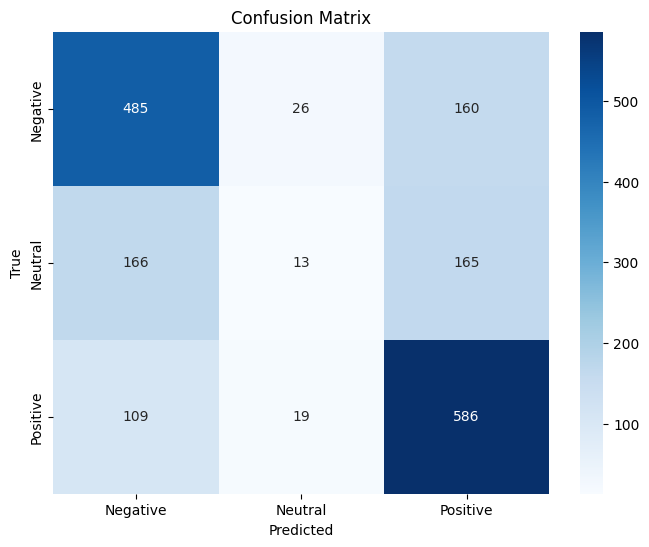

In [29]:
make_confusion_matrics(y_test, y_pred)

### LSTM Bidirectional Based Model

Defenindo e preparando as dados de traino e de teste.

In [14]:
bidirectional_lstm_model_checkpoint = "./checkpoints/bidirectional_lstm_model_checkpoint.h5"

X = rt_train["Text"].tolist()
y = rt_train["Sentiment"].tolist()

X_test = rt_test["Text"].tolist()
y_test = rt_test["Sentiment"].tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.transform(y_test)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)
max_len = max(len(x) for x in X)
X = pad_sequences(X, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

Carregando os GloVe embeddings e cosntruindo a matrix de embeddings

In [15]:
embeddings_index = {}
with open('./glove.6B/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Defenindo e compilando o modelo, juntamento com o carregamento do mesmo se este estiver previamente guardado

In [16]:
model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len),
    Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

try:
    model.load_weights(bidirectional_lstm_model_checkpoint)
except:
    pass

Trainar o modelo

In [10]:
checkpoint = ModelCheckpoint(bidirectional_lstm_model_checkpoint, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

model.fit(X, y, validation_split=0.2, epochs=1, batch_size=32, callbacks=callbacks_list)

 75/170 [============>.................] - ETA: 2s - loss: 1.0887 - accuracy: 0.3883

KeyboardInterrupt: 

Avaliando os dados de teste e calculando o valor das metricas de avaliação

In [17]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

accuracy = np.mean(y_pred == y_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

55/55 [==============================] - 1s 12ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.62      0.73      0.67       671
     neutral       0.25      0.06      0.10       344
    positive       0.66      0.79      0.72       714

    accuracy                           0.62      1729
   macro avg       0.51      0.53      0.50      1729
weighted avg       0.56      0.62      0.58      1729


Accuracy: 0.6194331983805668
Precision: 0.561478248168664
Recall: 0.6194331983805668
F1 Score: 0.5757353997087068


Construindo a matris de confusão

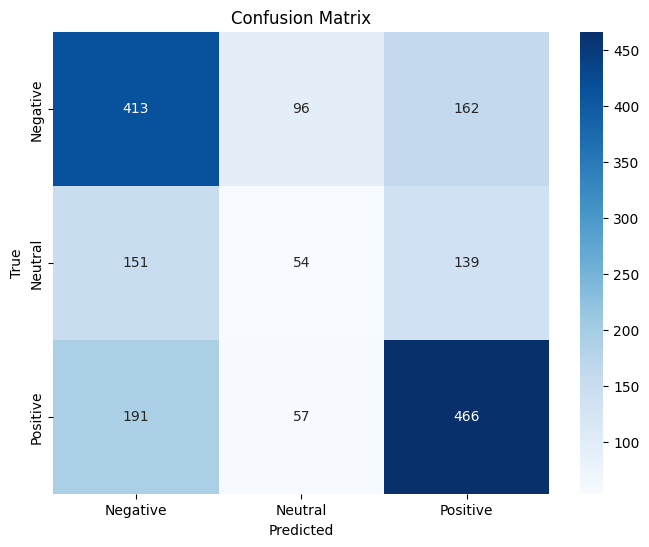

In [118]:
make_confusion_matrics(y_test, y_pred)

# 5 Utilização de transformadores para classificação
Deverá agora aplicar um modelo pré-treinado, baseado em transformadores, aos seus dados: 

a) Numa primeira etapa poderá fazer experiências simples, recorrendo a pipelines já definidos, aplicando um ou mais modelos existentes; 

b) Numa segunda etapa, use os seus dados para fazer fine tuning ao modelo pré-treinado e assim conseguir ainda melhores resultados.

### DistilBert Base Uncased pre-trained

Defenindo e preparando as dados de traino e de teste.

In [11]:
distilbert_model_checkpoint = "checkpoints/distilbert_model_checkpoint.h5"

X = rt_train["Text"].tolist()
y = rt_train["Sentiment"].tolist()

X_test = rt_test["Text"].tolist()
y_test = rt_test["Sentiment"].tolist()

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y_test = label_encoder.transform(y_test)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

X_train_encoded = tokenizer(X, padding=True, truncation=True, return_tensors='tf')
X_test_encoded = tokenizer(X_test, padding=True, truncation=True, return_tensors='tf')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Defenindo e compilando o modelo, juntamento com o carregamento do mesmo se este estiver previamente guardado

In [12]:
input_ids = tf.keras.Input(shape=(None,), name='input_ids', dtype='int32')
attention_mask = tf.keras.Input(shape=(None,), name='attention_mask', dtype='int32')
outputs = model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]
pooled_output = GlobalAveragePooling1D()(outputs)
dropout = Dropout(0.2)(pooled_output)
output = Dense(3, activation='softmax')(dropout)

model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(distilbert_model_checkpoint, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

try:
    model.load_weights(bidirectional_lstm_model_checkpoint)
except:
    pass

Treinar o modelo

In [15]:
history = model.fit({'input_ids': X_train_encoded['input_ids'], 'attention_mask': X_train_encoded['attention_mask']}, y,
                    validation_split=0.2, epochs=70, batch_size=32, callbacks=[checkpoint])

Epoch 1/70
170/170 [==============================] - ETA: 0s - loss: 0.8337 - accuracy: 0.6322
Epoch 1: val_accuracy improved from -inf to 0.69632, saving model to distilbert_model_checkpoint.h5
170/170 [==============================] - 547s 3s/step - loss: 0.8337 - accuracy: 0.6322 - val_loss: 0.7139 - val_accuracy: 0.6963
Epoch 2/70
170/170 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.7401
Epoch 2: val_accuracy did not improve from 0.69632
170/170 [==============================] - 532s 3s/step - loss: 0.6294 - accuracy: 0.7401 - val_loss: 0.7123 - val_accuracy: 0.6956
Epoch 3/70
170/170 [==============================] - ETA: 0s - loss: 0.5083 - accuracy: 0.7857
Epoch 3: val_accuracy did not improve from 0.69632
170/170 [==============================] - 550s 3s/step - loss: 0.5083 - accuracy: 0.7857 - val_loss: 0.7349 - val_accuracy: 0.6853
Epoch 4/70
170/170 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8463
Epoch 4: val_accur

KeyboardInterrupt: 

Avaliando os dados de teste e calculando o valor das metricas de avaliação

In [13]:
y_pred = model.predict({'input_ids': X_test_encoded['input_ids'], 'attention_mask': X_test_encoded['attention_mask']})
y_pred_labels = np.argmax(y_pred, axis=1)

y_pred_labels = label_encoder.inverse_transform(y_pred_labels)
y_test_labels = label_encoder.inverse_transform(y_test)

report = classification_report(y_test_labels, y_pred_labels, labels=np.unique(y_test_labels), output_dict=True)

print("Classification Report:")
print(classification_report(y_test_labels, y_pred_labels))

accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

55/55 [==============================] - 37s 658ms/step
Classification Report:
              precision    recall  f1-score   support

    negative       0.40      0.00      0.01       671
     neutral       0.00      0.00      0.00       344
    positive       0.41      1.00      0.59       714

    accuracy                           0.41      1729
   macro avg       0.27      0.33      0.20      1729
weighted avg       0.33      0.41      0.24      1729


Accuracy: 0.41353383458646614
Precision: 0.32621986485914595
Recall: 0.41353383458646614
F1 Score: 0.2440346624884689


Construindo a matrix de confusão

In [114]:
make_confusion_matrics(y_test_labels, y_pred_labels)

NameError: name 'y_test_labels' is not defined